In [1]:
import os
import datetime

import sys

sys.path.append("..")
import datetime, time, os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from functions import df_security_code

import tensorflow as tf

from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Data

In [2]:
data = pd.read_csv('../data/curr_price_financial_fill.csv', parse_dates=['Date'],  index_col=[0])
df = df_security_code(data)
del data

In [3]:
df.columns
df = df.iloc[:,5:]
df.drop(['margin_growth', 'win_quarter_growth', 'margin', 'NetSales', 'Profit',
       'Day_cos', 'Year', 'rev_quarter_growth'], axis = 1, inplace=True)

In [4]:
df.head(2)

,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,ad_Close_lag1,ad_Close_sma10,logprice_ad_Close,detrend_ad_Close,...,macd_s,Day,Month,week,Volatility_week,Day_sin,Month_sin,Month_cos,Year_sin,Year_cos
0,7010.0,7103.0,6975.0,7097.0,9547600.0,-0.016882,NaN,NaN,8.867427,7097.0,...,NaN,4.0,1.0,1.0,1.619015,-1.405899e-12,0.046905,-0.998899,0.061933,0.998080
1,7090.0,7091.0,7023.0,7049.0,7644000.0,-0.009957,7097.0,NaN,8.860641,7049.0,...,NaN,5.0,1.0,1.0,1.619015,-1.165928e-11,-0.158971,-0.987283,0.079093,0.996867


In [5]:
def split_train_val_test(df, split=22):
    df.dropna(inplace=True)
    df_train =  df[:- 2*split]
    df_val = df[- 2*split : - split]
    df_test = df[- split : ]

    return df_train, df_val, df_test

In [6]:
train_data, val_data, test_data = split_train_val_test(df=df)
print(df.shape)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(1169, 50)
(1125, 50)
(22, 50)
(22, 50)


In [7]:
num_features = train_data.shape[1]

In [8]:
def scaling_df(df):

    #scaler = StandardScaler()
    #scaler2 = MinMaxScaler()
    #df_scaled = scaler.fit_transform(df)
    #df_scaled = scaler2.fit_transform(df_scaled)
    #df_scaled = pd.DataFrame(df_scaled)
    #df_scaled.columns = df.columns
    
    #df_mean = df.mean()
    #df_std = df.std()

    #df_scaled = (df-df_mean) / df_std 
    
    return df #df_scaled

In [9]:
train_df = scaling_df(train_data)
val_df = scaling_df(val_data)
test_df = scaling_df(test_data)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1125, 50)
(22, 50)
(22, 50)


# Setup Tensorboard

In [10]:
!rm -rf my_logs/
# Define path for new directory 
root_logdir = os.path.join(os.curdir, "my_logs")

# Define function for creating a new folder for each run
def get_run_logdir():
    run_id = time.strftime('run_%d_%m_%Y-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

# Create function for using callbacks; "name" should be the name of the model you use
def get_callbacks(name):
    return tf.keras.callbacks.TensorBoard(run_logdir+name, histogram_freq=1)


# Modelling

In [11]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_df))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-04-28 01:12:22.594272: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-28 01:12:22.594381: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-28 01:12:22.625687: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-28 01:12:22.686585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-28 01:12:22.702626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [12]:
#normalizer(train_df).numpy().mean()

In [13]:
normalizer(train_df)

<tf.Tensor: shape=(1125, 50), dtype=float32, numpy=
array([[-0.811, -0.831, -0.775, ...,  1.27 ,  1.06 ,  1.006],
       [-0.738, -0.789, -0.75 , ...,  1.117,  1.075,  0.987],
       [-0.779, -0.806, -0.76 , ...,  0.916,  1.09 ,  0.967],
       ...,
       [ 3.367,  3.334,  3.272, ..., -0.483, -1.429,  0.02 ],
       [ 3.198,  3.274,  3.222, ..., -0.749, -1.43 ,  0.044],
       [ 3.388,  3.313,  3.007, ..., -0.983, -1.431,  0.069]],
      dtype=float32)>

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=normalizer(train_df), 
               val_df=normalizer(val_df), 
               test_df=normalizer(test_df),
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_data.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    #self.example = 

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def plot(self, model=None, plot_col='ad_Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model.predict(inputs) # add predict
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [17]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

@property
def separe_map_train(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result



WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.separe_map = separe_map_train


In [19]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min'
                                                    )

  model.compile(loss='mae', #tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics= 'mse' )# [tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      #callbacks=[early_stopping]
                      )
  return history

# Multisteps

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

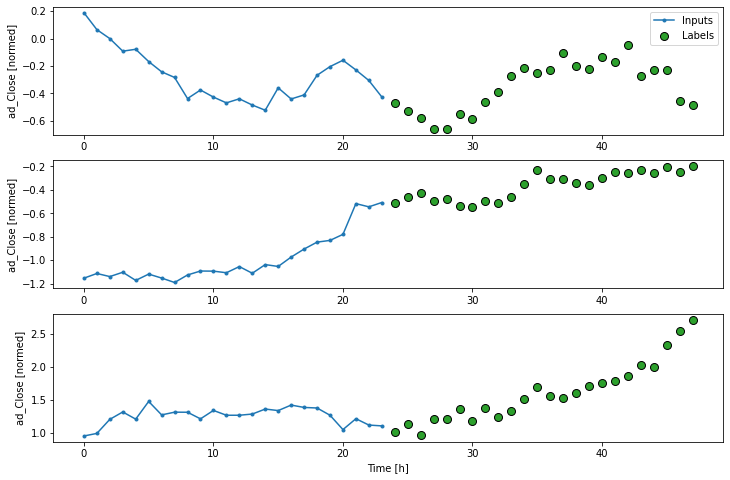

In [20]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)
IPython.display.clear_output()

multi_window.plot()
multi_window

In [21]:
inputs_test, labels_test = multi_window.separe_map
inputs_example, labels_example = multi_window.example

1/1 [==============================] - 0s 143ms/step - loss: 0.7901 - mean_absolute_error: 0.5514


2022-04-28 01:12:23.667407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-28 01:12:23.803705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


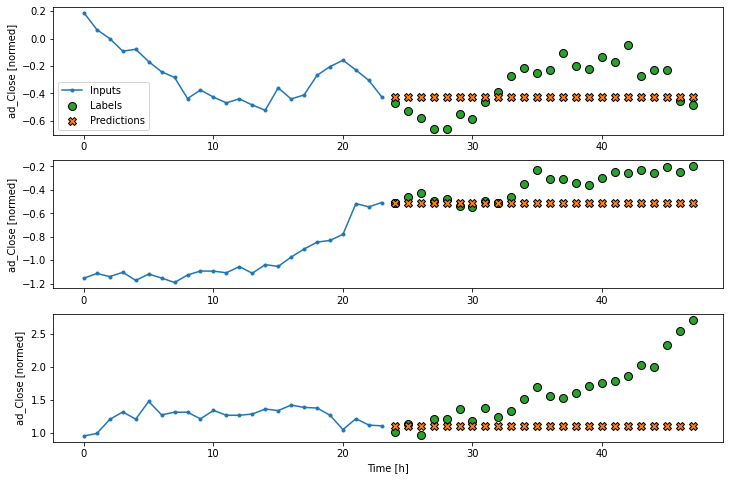

In [22]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

#inputs, labels = separe_map(multi_window)
#inputs, labels = multi_window.separe_map
multi_val_performance['Last'] = last_baseline.evaluate(inputs_example, labels_example )
#multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_performance['Last'] = last_baseline.evaluate(inputs_test, labels_test, verbose=0)
multi_window.plot(last_baseline)

1/1 [==============================] - 0s 66ms/step - loss: 0.9016 - mean_absolute_error: 0.6391


2022-04-28 01:12:24.199805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-28 01:12:24.290045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


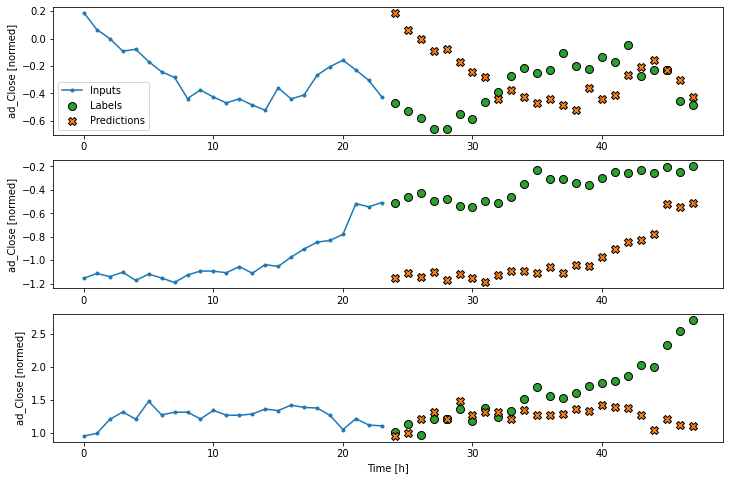

In [23]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

#inputs, labels = multi_window.separe_map
multi_val_performance['Repeat'] = repeat_baseline.evaluate(inputs_example, labels_example)
#multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_performance['Repeat'] = repeat_baseline.evaluate(inputs_test, labels_test, verbose=0)
multi_window.plot(repeat_baseline)

1/1 [==============================] - 0s 61ms/step - loss: 0.3110 - mse: 0.2963


2022-04-28 01:12:29.492448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-28 01:12:29.578113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


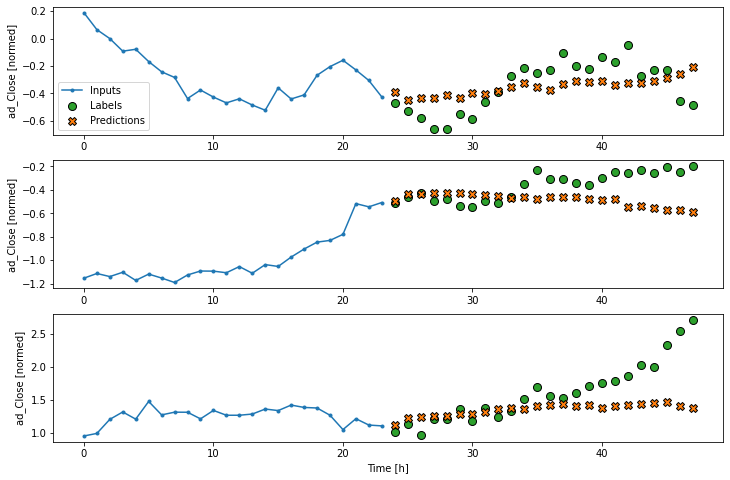

In [24]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)
#inputs, labels = multi_window.separe_map

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(inputs_example, labels_example)
#multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_performance['Linear'] = multi_linear_model.evaluate(inputs_test, labels_test, verbose=0)
multi_window.plot(multi_linear_model)

In [25]:
hist = pd.DataFrame(history.history)
hist

1/1 [==============================] - 0s 73ms/step - loss: 0.2470 - mse: 0.2291


2022-04-28 01:12:36.560964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-28 01:12:36.658617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


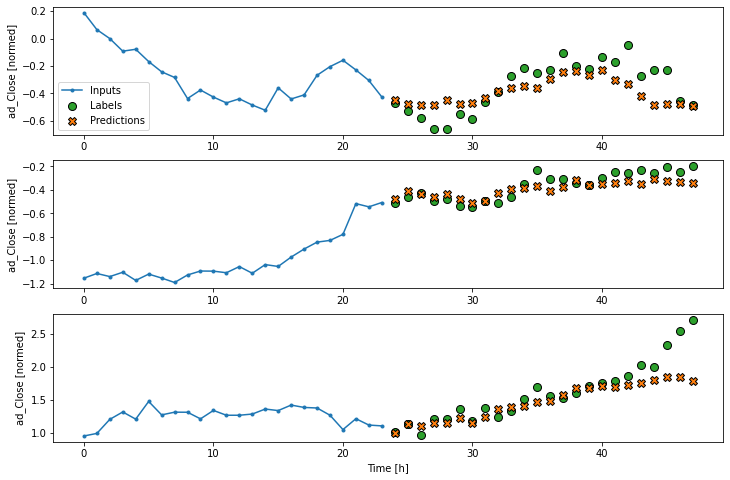

In [26]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

#inputs, labels = multi_window.separe_map
IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(inputs_example, labels_example)
multi_performance['Dense'] = multi_dense_model.evaluate(inputs_test, labels_test, verbose=0)
multi_window.plot(multi_dense_model)

1/1 [==============================] - 0s 83ms/step - loss: 0.2340 - mse: 0.2081


2022-04-28 01:12:42.931269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-28 01:12:43.041479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


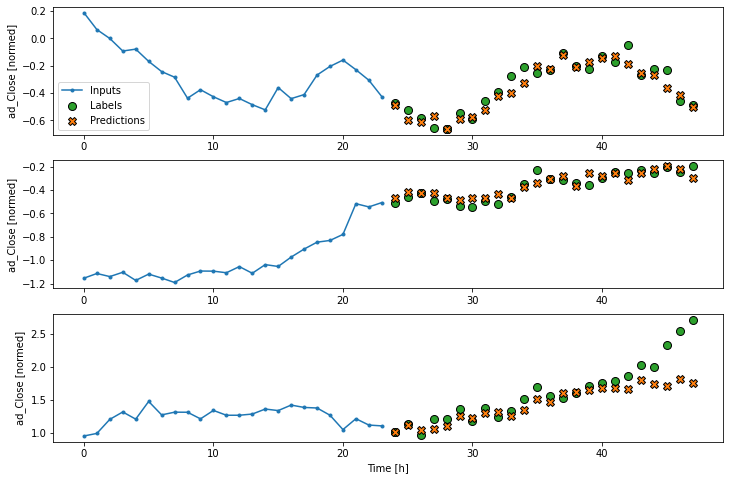

In [27]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()
#inputs, labels = multi_window.separe_map
multi_val_performance['Conv'] = multi_conv_model.evaluate(inputs_example, labels_example)
multi_performance['Conv'] = multi_conv_model.evaluate(inputs_test, labels_test, verbose=0)
multi_window.plot(multi_conv_model)

In [40]:
multi_conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 3, 50)             0         
                                                                 
 conv1d (Conv1D)             (None, 1, 256)            38656     
                                                                 
 dense_3 (Dense)             (None, 1, 1200)           308400    
                                                                 
 reshape_2 (Reshape)         (None, 24, 50)            0         
                                                                 
Total params: 347,056
Trainable params: 347,056
Non-trainable params: 0
_________________________________________________________________


In [28]:
hist = pd.DataFrame(history.history)

1/1 [==============================] - 1s 507ms/step - loss: 0.2668 - mse: 0.2474


2022-04-28 01:12:54.108976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-28 01:12:54.159456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-04-28 01:12:54.394480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-28 01:12:54.428204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


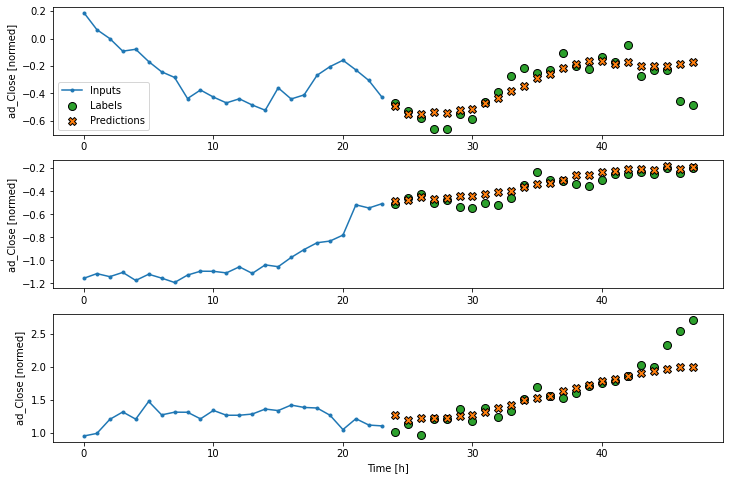

In [29]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    #tf.keras.layers.Normalization(axis=None), #added
    #tf.keras.layer.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()
#inputs, labels = multi_window.separe_map
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(inputs_example, labels_example)
multi_performance['LSTM'] = multi_lstm_model.evaluate(inputs_test, labels_test, verbose=0)
multi_window.plot(multi_lstm_model)

In [30]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [31]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [32]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup


In [33]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 50])

In [34]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

2022-04-28 01:20:07.019768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.3571 - mse: 0.3552


2022-04-28 01:20:08.351813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


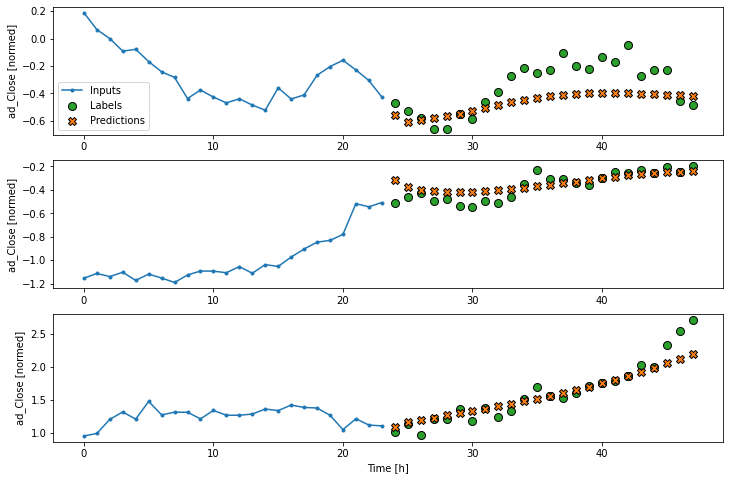

In [35]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()
#inputs, labels= multi_window.separe_map
multi_val_performance['AR LSTM'] = feedback_model.evaluate(inputs_example, labels_example)
multi_performance['AR LSTM'] = feedback_model.evaluate(inputs_test, labels_test, verbose=0)
multi_window.plot(feedback_model)

In [36]:
pd.DataFrame(multi_performance, index=['Mean Squared Error [ad_Close]', 'Mean Absolute error [ad_Close]'] ).T


,Mean Squared Error [ad_Close],Mean Absolute error [ad_Close]
Last,0.790061,0.551431
Repeat,0.901576,0.639106
Linear,0.311036,0.296295
Dense,0.247037,0.229119
Conv,0.233963,0.208142
LSTM,0.266822,0.247380
AR LSTM,0.357104,0.355184


In [37]:

pd.DataFrame(multi_val_performance, index=['Mean Squared Error [ad_Close]', 'Mean Absolute error [ad_Close]'] ).T


,Mean Squared Error [ad_Close],Mean Absolute error [ad_Close]
Last,0.790061,0.551431
Repeat,0.901576,0.639106
Linear,0.311036,0.296295
Dense,0.247037,0.229119
Conv,0.233963,0.208142
LSTM,0.266822,0.247380
AR LSTM,0.357104,0.355184
